In [2]:
import sys
import numpy as np
import os
import cv2
import logging
from image_utils import standardize
import matplotlib.pyplot as plt
from dataset_generator import DatasetGenerator
import torch
import torch.nn.functional as Fu
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
from unet_val import UNet
import torch.backends.cudnn as cudnn

In [3]:
##########
GLOBAL_PATH='MODEL_BASIC_TEST_120/'
##########

if not os.path.exists(GLOBAL_PATH):
            os.makedirs(GLOBAL_PATH)
        
#############
PATH_TRAINING='TRAINING/'
PATH_VALIDATION='VALIDATION/'
PATH_TEST='TEST/'

PATH_INPUT='INPUT/'
PATH_OUTPUT='OUTPUT/'
##############

        
INPUT_CHANNELS=9
OUTPUT_CHANNELS=2
NB_CLASSES=2

SIZE_PATCH=120
##############
MODEL_PATH_SAVE=GLOBAL_PATH+'RESUNET_BASIC_test.ckpt'
MODEL_PATH_RESTORE=''
TEST_SAVE=GLOBAL_PATH+'TEST_SAVE/'
if not os.path.exists(TEST_SAVE):
            os.makedirs(TEST_SAVE)
        
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

##############

REC_SAVE=1#2000
DROPOUT=0.9#0.9
DEFAULT_BATCH_SIZE = 10#10
DEFAULT_EPOCHS = 2#50
DEFAULT_ITERATIONS =3#495
DEFAULT_VALID=5#100
DISPLAY_STEP=1#50

###############
DEFAULT_LAYERS=3
DEFAULT_FEATURES_ROOT=32
DEFAULT_FILTERS_SIZE=3
DEFAULT_LR=0.0001


In [4]:
 class Trainer(object):
    """
    Trains a unet instance
    
    :param net: the unet instance to train
    :param batch_size: size of training batch
    :param lr: learning rate
    """
    def __init__(self, net, batch_size=10, lr=0.0001):
        self.net = net
        self.batch_size = batch_size
        self.lr = lr
 
    
    def _initialize(self, prediction_path):
        
        self.optimizer = optim.Adam(self.net.parameters(),lr=self.lr)
        
        self.prediction_path = prediction_path
        
    
    def train(self, data_provider_path, save_path='', restore_path='', training_iters=4, epochs=3, dropout=0.9, display_step=1, validation_batch_size=30,rec_save=1, prediction_path = ''):
        """
        Lauches the training process
        
        :param data_provider_path: where the DATASET folder is
        :param save_path: path where to store checkpoints
        :param restore_path: path where is the model to restore is stored
        :param training_iters: number of training mini batch iteration
        :param epochs: number of epochs
        :param dropout: dropout probability
        :param display_step: number of steps till outputting stats
        :param restore: Flag if previous model should be restored 
        :param prediction_path: path where to save predictions on each epoch
        """
        
        PATH_TRAINING=data_provider_path+'TRAINING/'
        PATH_VALIDATION=data_provider_path+'VALIDATION/'
        PATH_TEST=data_provider_path+'TEST/'
        
        #STORE PSNR for ANALYSIS
        loss_train=np.zeros(training_iters*epochs)
        file_train = open(TEST_SAVE+'loss_train.txt','w') 
        loss_verif=np.zeros(epochs)
        file_verif = open(TEST_SAVE+'loss_verif.txt','w') 
        
        if epochs == 0:
            return save_path
        if save_path=='':
            return 'Specify a path where to store the Model'
        self._initialize(prediction_path)
            
        if restore_path=='':
            print('Model trained from scratch')
        else:
            self.net.load_state_dict(torch.load(restore_path))
            print('Model loaded from {}'.format(restore_path))
            

        val_generator = DatasetGenerator.from_root_folder(PATH_VALIDATION, batch_size=validation_batch_size)
        val_generator=val_generator.shuffled()
        val_generator=val_generator.__iter__()
        X_val,Y_val=val_generator.__next__()
        X_val=standardize(X_val)
        
        
        self.store_validation(X_val, Y_val, "_init",validation_batch_size,save_patches=True)

        train_len = self.batch_size*training_iters
        training_generator = DatasetGenerator.from_root_folder(PATH_TRAINING, batch_size=self.batch_size)

        logging.info("Start optimization")

        counter=0
        for epoch in range(epochs):
            total_loss = 0
            training_generator_ite=training_generator.shuffled()
            training_generator_ite=training_generator_ite.__iter__()

            for step in range((epoch*training_iters), ((epoch+1)*training_iters)):

                batch_x,batch_y =training_generator_ite.__next__()
                batch_x=standardize(batch_x)
                prediction,loss=self.predict(batch_x,batch_y)
                # Run optimization op (backprop)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()


                if step % display_step == 0:
                    self.output_minibatch_stats(step, batch_x,batch_y)

                total_loss += loss.data[0]
                loss_train[counter]=loss
                file_train.write(str(loss_train[counter])+'\n')
                counter += 1
                if counter % rec_save == 0:
                    torch.save(self.net.state_dict(),save_path + 'CP{}.pth'.format(counter))
                    print('Checkpoint {} saved !'.format(counter))



            self.output_epoch_stats(epoch, total_loss, training_iters, self.lr)
            loss_v=self.store_validation( X_val, Y_val, "epoch_%s"%epoch,validation_batch_size,save_patches=False)
            loss_verif[epoch]=loss_v
            file_verif.write(str(loss_verif[epoch])+'\n')
        torch.save(self.net.state_dict(),save_path + 'CP{}.pth'.format(counter))
        loss_v=self.store_validation( X_val, Y_val, "epoch_%s"%epoch,validation_batch_size,save_patches=True)
        print('Checkpoint {} saved !'.format(counter))

        logging.info("Optimization Finished!")

        return save_path, loss_train,loss_verif
    
    def predict(self,batch_x,batch_y):
        X=np.transpose(batch_x, axes=[0,3,1,2])
        X = torch.FloatTensor(X)
        X = Variable(X).cuda()
        Y=np.transpose(batch_y, axes=[0,3,1,2])
        Y = torch.FloatTensor(Y)
        Y = Variable(Y).cuda()
        
        y_pred=self.net(X)
        probs = Fu.softmax(y_pred,dim=1)
        loss=Fu.binary_cross_entropy_with_logits(probs,Y)
        probs=probs.data.cpu().numpy()
        probs=np.transpose(probs, axes=[0,2,3,1])
        return probs,loss
            

    def store_validation(self,batch_x, batch_y, name,validation_batch_size,*,save_patches=True):
        
        prediction,loss=self.predict(batch_x,batch_y)
        loss=loss.data[0]
        logging.info("Verification error= {:.1f}%, loss= {:.4f}".format(error_rate(prediction,batch_y),loss))
        
        plot_summary(prediction,batch_y,batch_x[:,:,:,0],validation_batch_size,name,self.prediction_path,save_patches)

        return loss
    def output_epoch_stats(self, epoch, total_loss, training_iters, lr):
        logging.info("Epoch {:}, Average loss: {:.4f}, learning rate: {:.4f}".format(epoch, (total_loss / training_iters), lr))

    def output_minibatch_stats(self, step, batch_x, batch_y):
        # Calculate batch loss and accuracy
        predictions,loss=self.predict(batch_x,batch_y)
        loss=loss.data[0]
        logging.info("Iter {:}, Minibatch Loss= {:.4f}, Training Accuracy= {:.4f}, Minibatch error= {:.1f}%".format(step,
                                                                                                                    loss,
                                                                                                                    accuracy_(predictions,batch_y),
                                                                                                                    error_rate(predictions, batch_y)))

    # #         fig,axs=plt.subplots(3, 3,figsize=(8*3,24))

    # #         axs[0,0].set_title(str(step)+' Panchromatic ', fontsize='large')
    # #         axs[1,0].set_title(str(step)+' Groundtruth ', fontsize='large')
    # #         axs[2,0].set_title(str(step)+' Predictions ', fontsize='large')


    # #         for i in range(3):

    # #             axs[0,i].imshow(batch_x[i,:,:,0])
    # #             axs[1,i].imshow(batch_y[i,:,:,0])
    # #             logits=np.argmax(predictions, 3)
    # #             axs[2,i].imshow(1-logits[i,:,:])

    # #         plt.subplots_adjust()
    # #     #     suptitle.set_y(0.95)
    # #     #     fig.subplots_adjust(top=0.96)
    # #         plt.show()

In [5]:
def error_rate(predictions, labels):
    """
    Return the error rate based on dense predictions and 1-hot labels.
    """

    return 100.0 - (
        100.0 *
        np.sum(np.argmax(predictions, 3) == np.argmax(labels, 3)) /
        (predictions.shape[0]*predictions.shape[1]*predictions.shape[2]))

def accuracy_(predictions, labels):
    return 100.0 *np.sum(np.argmax(predictions, 3) == np.argmax(labels, 3)) /(predictions.shape[0]*predictions.shape[1]*predictions.shape[2])
    
    
def plot_summary(predictions,labels,panchro,batch_size,epoch,prediction_path,save_patches):
    
    fig,axs=plt.subplots(3, batch_size,figsize=(8*batch_size,24))

    axs[0,0].set_title(epoch+' Panchromatic ', fontsize='large')
    axs[1,0].set_title(epoch+' Groundtruth ', fontsize='large')
    axs[2,0].set_title(epoch+' Predictions ', fontsize='large')

        
    for i in range(batch_size):
        
        axs[0,i].imshow(panchro[i,:,:])
        plt.imsave(prediction_path+epoch+'_Panchro_'+str(i)+'.jpg',panchro[i,:,:])
        axs[1,i].imshow(labels[i,:,:,0])
        logits=np.argmax(predictions, 3)
        axs[2,i].imshow(1-logits[i,:,:])
        
        if save_patches:
            plt.imsave(prediction_path+epoch+'_Groundtruth_'+str(i)+'.jpg',labels[i,:,:,0])
            plt.imsave(prediction_path+epoch+'_Predictions_'+str(i)+'.jpg',1-logits[i,:,:])

    plt.subplots_adjust()
#     suptitle.set_y(0.95)
#     fig.subplots_adjust(top=0.96)
    plt.show()

# def _update_avg_gradients(avg_gradients, gradients, step):
#     if avg_gradients is None:
#         avg_gradients = [np.zeros_like(gradient) for gradient in gradients]
#     for i in range(len(gradients)):
#         avg_gradients[i] = (avg_gradients[i] * (1.0 - (1.0 / (step+1)))) + (gradients[i] / (step+1))
        
#     return avg_gradients


Model trained from scratch


/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:180: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")
2018-03-27 21:46:30,435 Verification error= 28.6%, loss= 0.7001


torch.Size([5, 32, 120, 120])
torch.Size([5, 64, 60, 60])
torch.Size([5, 64, 60, 60])
torch.Size([5, 128, 30, 30])
torch.Size([5, 128, 30, 30])
torch.Size([5, 128, 15, 15])


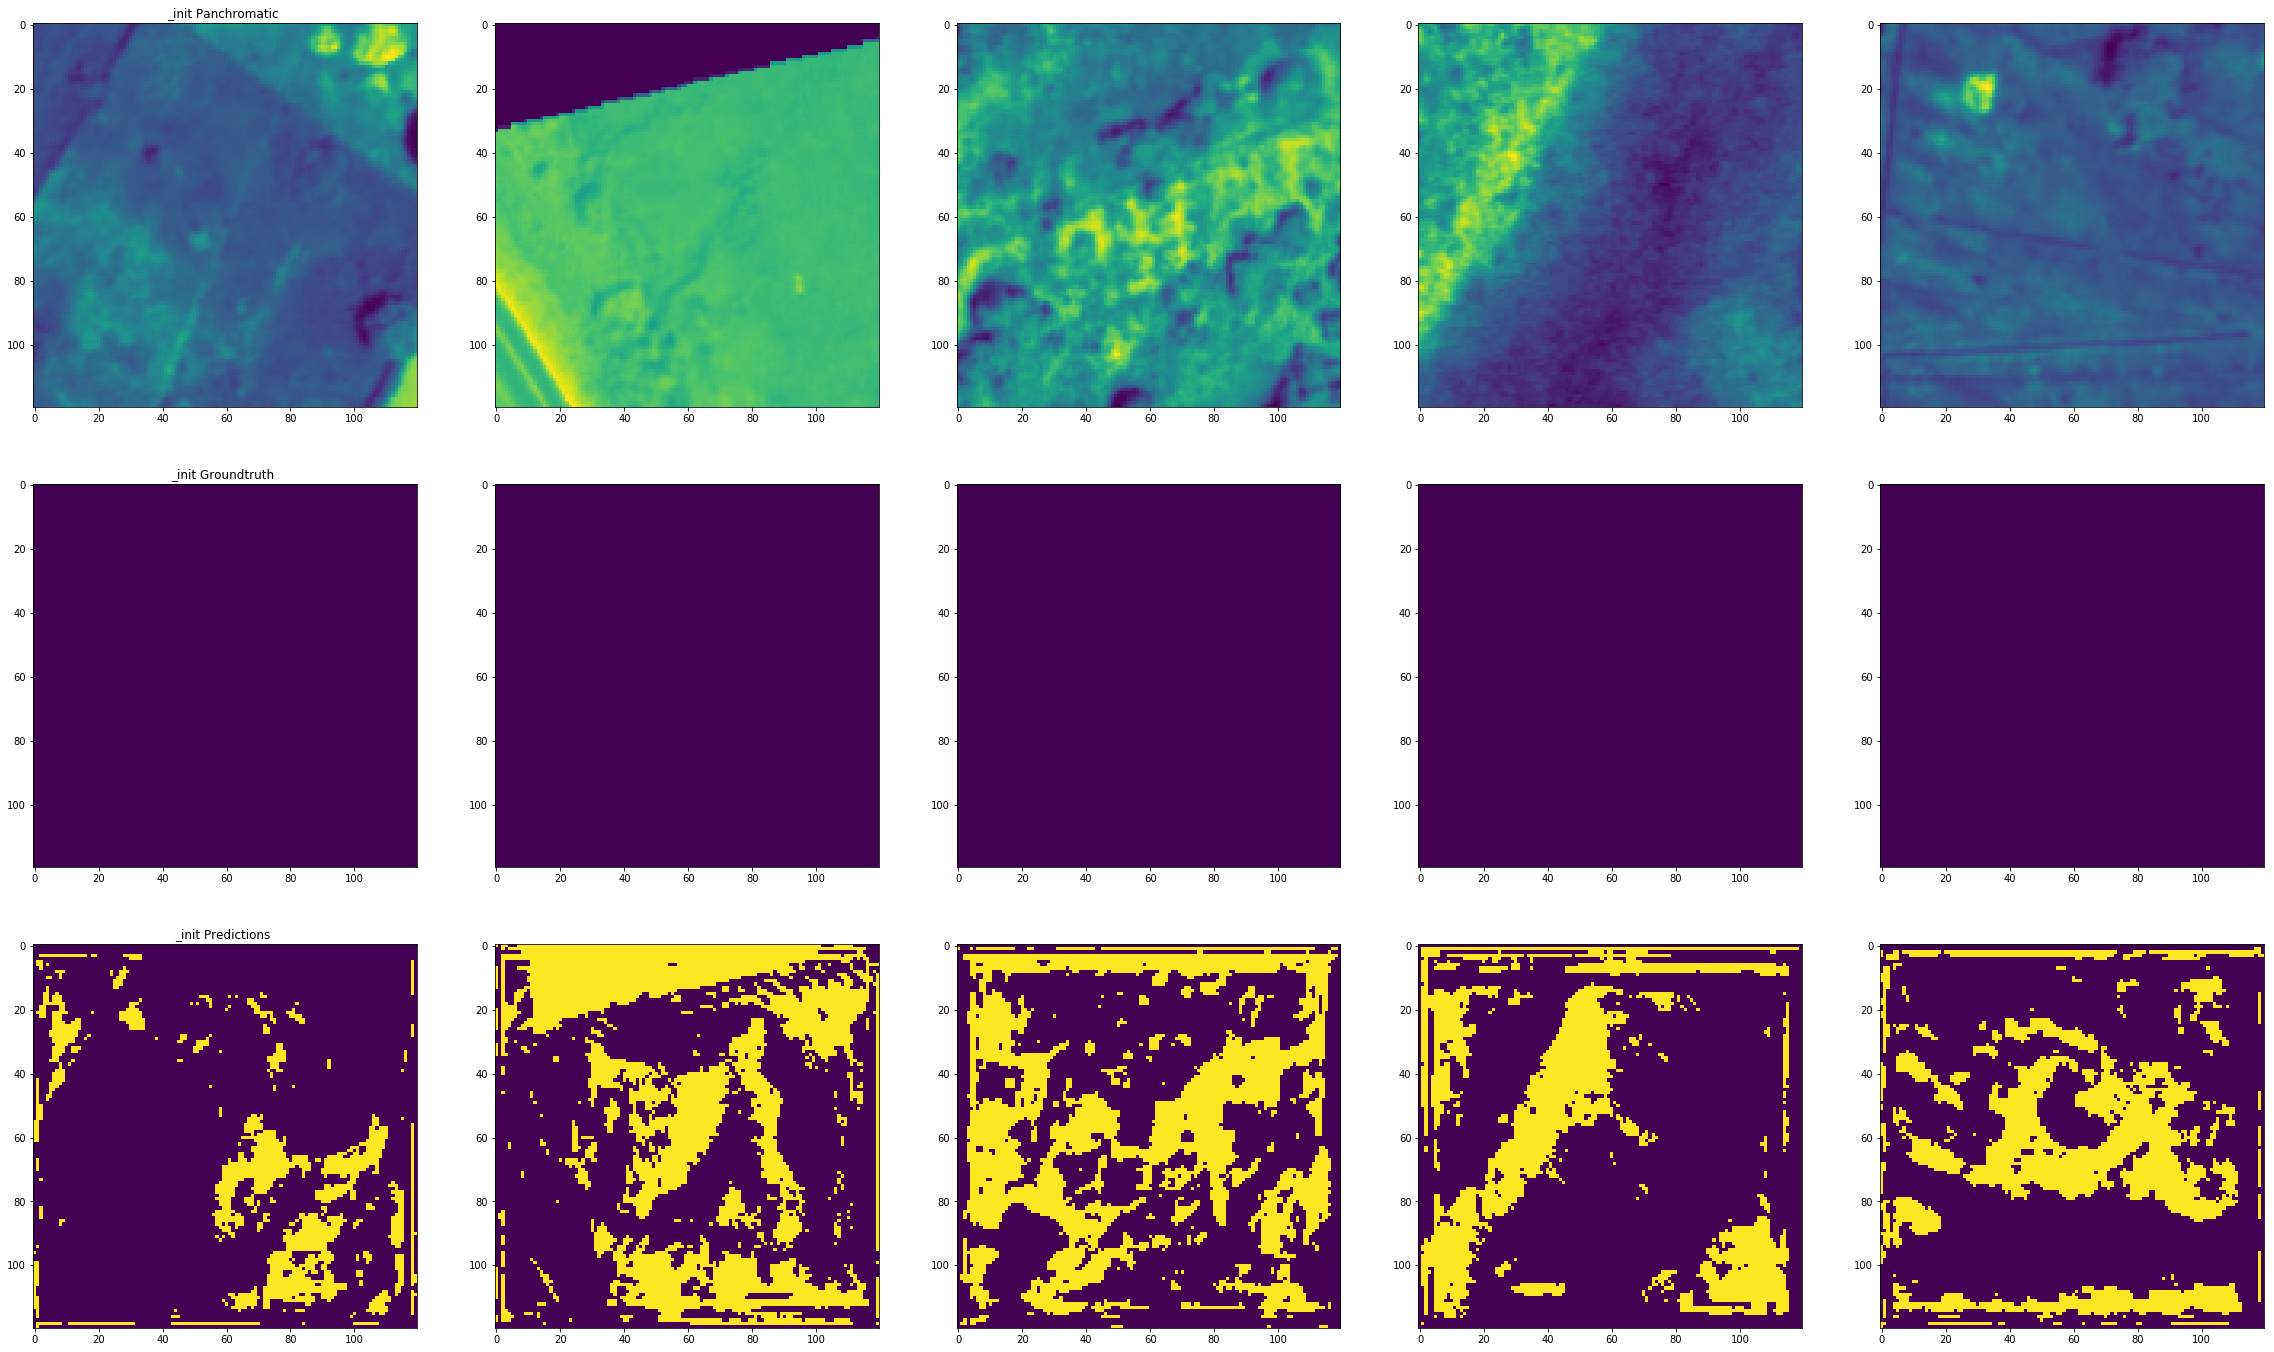

2018-03-27 21:46:33,231 Start optimization


torch.Size([10, 32, 120, 120])
torch.Size([10, 64, 60, 60])
torch.Size([10, 64, 60, 60])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 15, 15])


2018-03-27 21:46:34,177 Iter 0, Minibatch Loss= 0.6918, Training Accuracy= 78.8181, Minibatch error= 21.2%


torch.Size([10, 32, 120, 120])
torch.Size([10, 64, 60, 60])
torch.Size([10, 64, 60, 60])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 15, 15])
Checkpoint 1 saved !


2018-03-27 21:46:34,986 Iter 1, Minibatch Loss= 0.6932, Training Accuracy= 79.1125, Minibatch error= 20.9%


torch.Size([10, 32, 120, 120])
torch.Size([10, 64, 60, 60])
torch.Size([10, 64, 60, 60])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 15, 15])
torch.Size([10, 32, 120, 120])
torch.Size([10, 64, 60, 60])
torch.Size([10, 64, 60, 60])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 15, 15])
Checkpoint 2 saved !


2018-03-27 21:46:35,640 Iter 2, Minibatch Loss= 0.6956, Training Accuracy= 77.8340, Minibatch error= 22.2%
2018-03-27 21:46:35,724 Epoch 0, Average loss: 0.6983, learning rate: 0.0001
2018-03-27 21:46:35,733 Verification error= 19.0%, loss= 0.6944


torch.Size([10, 32, 120, 120])
torch.Size([10, 64, 60, 60])
torch.Size([10, 64, 60, 60])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 15, 15])
torch.Size([10, 32, 120, 120])
torch.Size([10, 64, 60, 60])
torch.Size([10, 64, 60, 60])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 15, 15])
Checkpoint 3 saved !
torch.Size([5, 32, 120, 120])
torch.Size([5, 64, 60, 60])
torch.Size([5, 64, 60, 60])
torch.Size([5, 128, 30, 30])
torch.Size([5, 128, 30, 30])
torch.Size([5, 128, 15, 15])


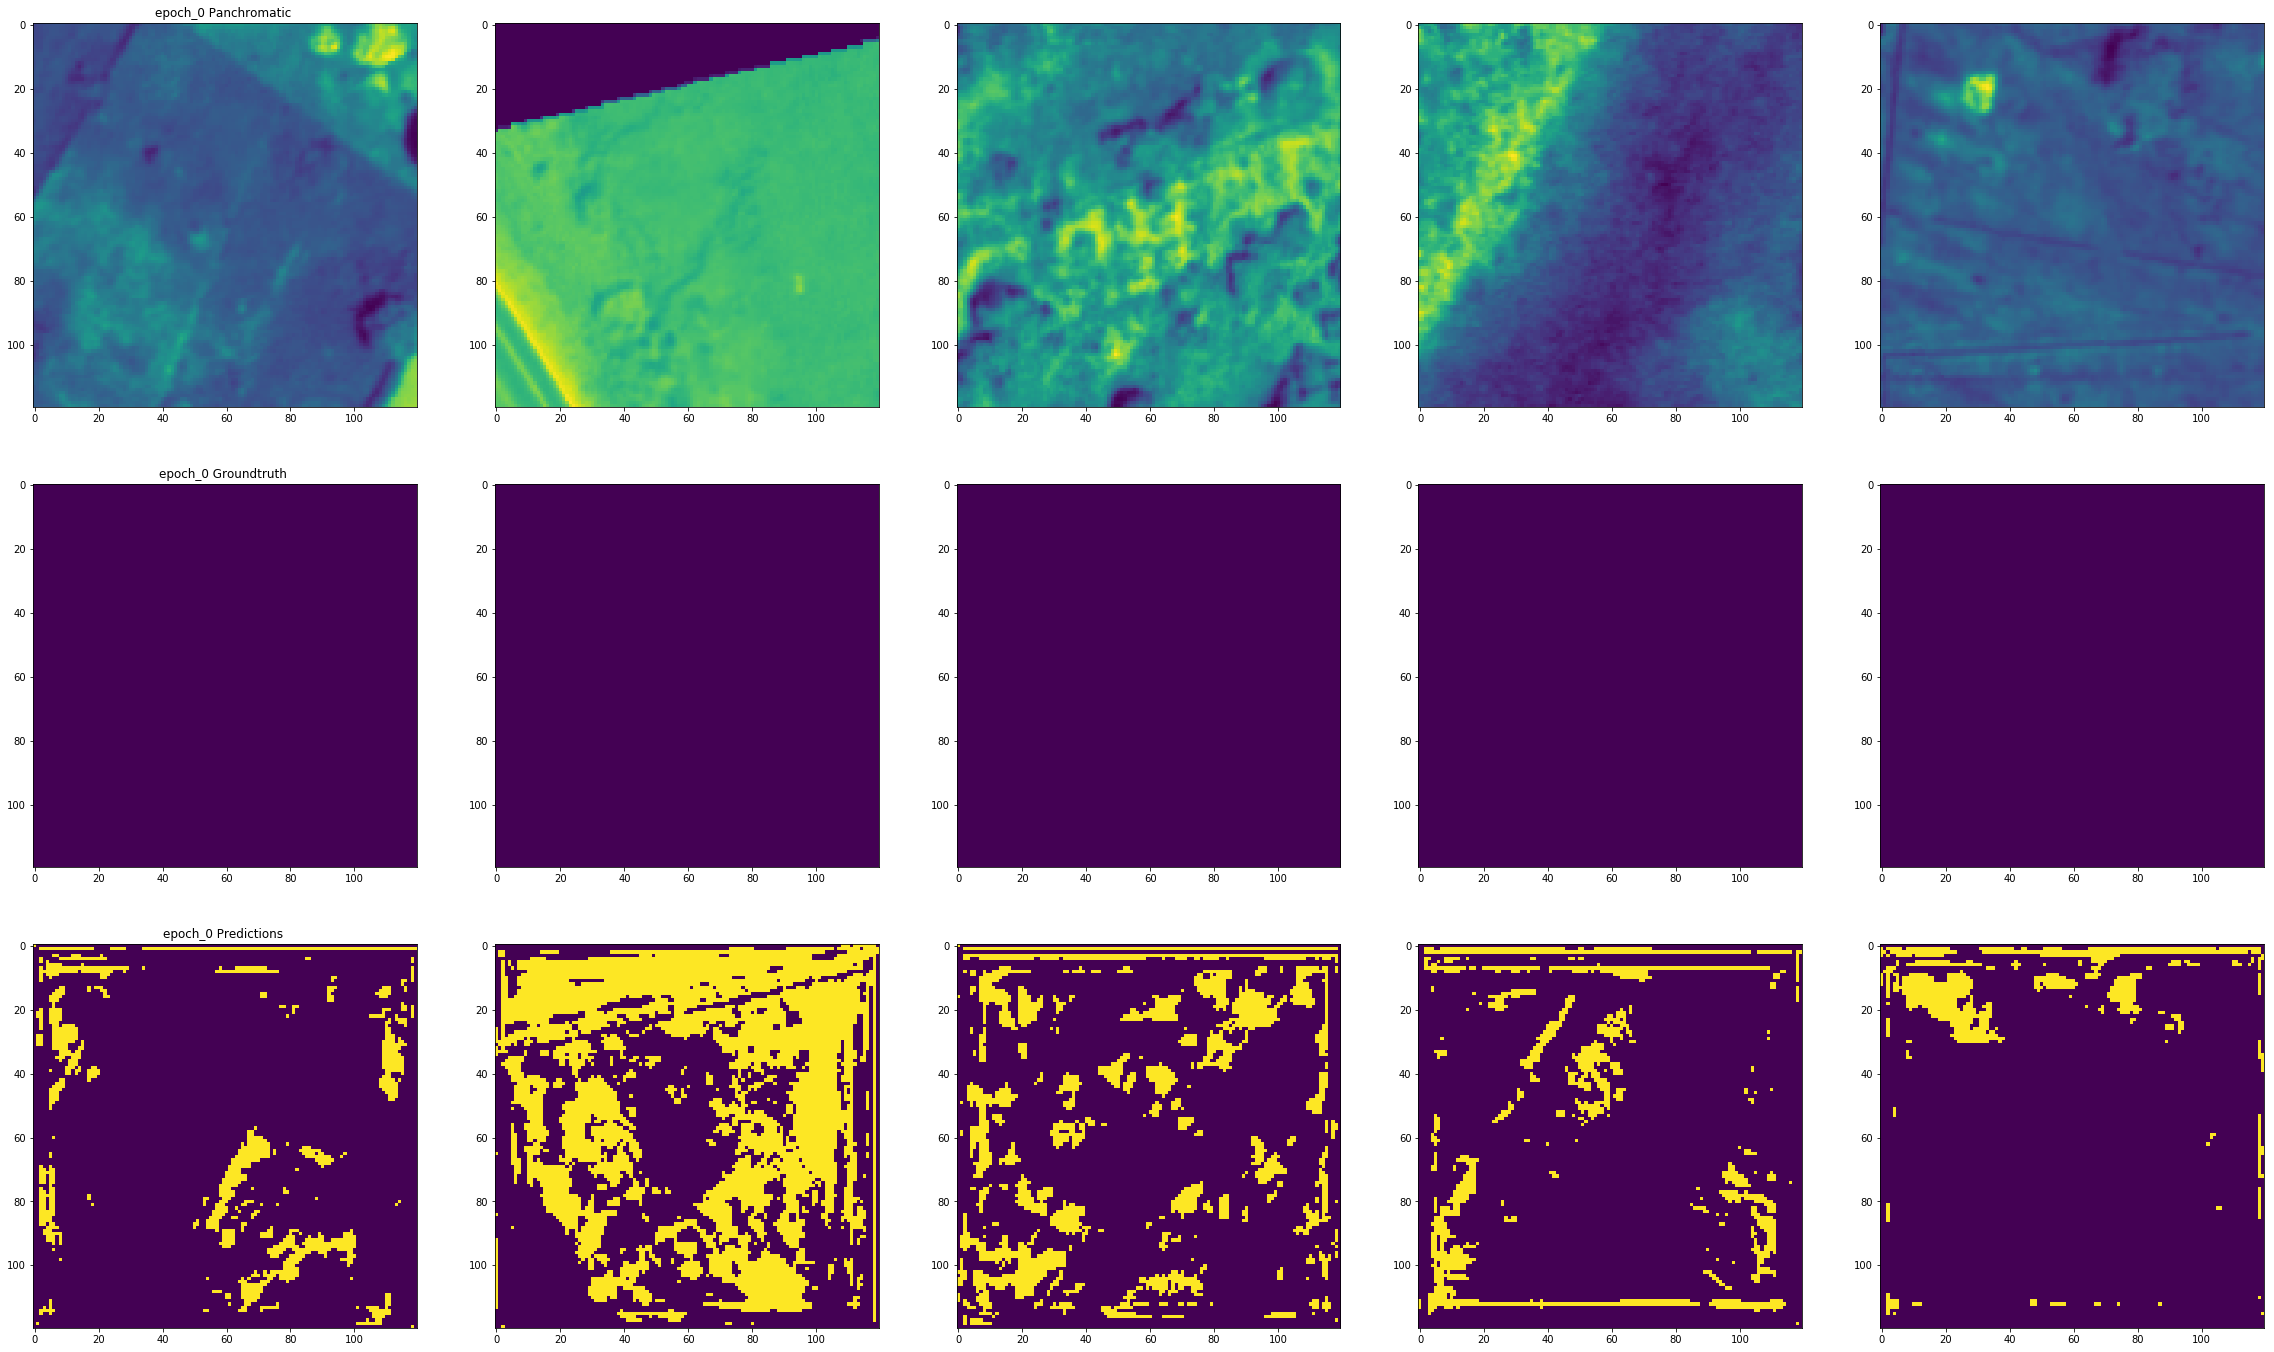

2018-03-27 21:46:38,005 Iter 3, Minibatch Loss= 0.6874, Training Accuracy= 85.3306, Minibatch error= 14.7%


torch.Size([10, 32, 120, 120])
torch.Size([10, 64, 60, 60])
torch.Size([10, 64, 60, 60])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 15, 15])
torch.Size([10, 32, 120, 120])
torch.Size([10, 64, 60, 60])
torch.Size([10, 64, 60, 60])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 15, 15])
Checkpoint 4 saved !


2018-03-27 21:46:38,694 Iter 4, Minibatch Loss= 0.6892, Training Accuracy= 84.0118, Minibatch error= 16.0%


torch.Size([10, 32, 120, 120])
torch.Size([10, 64, 60, 60])
torch.Size([10, 64, 60, 60])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 15, 15])
torch.Size([10, 32, 120, 120])
torch.Size([10, 64, 60, 60])
torch.Size([10, 64, 60, 60])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 15, 15])
Checkpoint 5 saved !


2018-03-27 21:46:40,308 Iter 5, Minibatch Loss= 0.6865, Training Accuracy= 84.9917, Minibatch error= 15.0%


torch.Size([10, 32, 120, 120])
torch.Size([10, 64, 60, 60])
torch.Size([10, 64, 60, 60])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 15, 15])
torch.Size([10, 32, 120, 120])
torch.Size([10, 64, 60, 60])
torch.Size([10, 64, 60, 60])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 30, 30])
torch.Size([10, 128, 15, 15])


2018-03-27 21:46:40,474 Epoch 1, Average loss: 0.6897, learning rate: 0.0001
2018-03-27 21:46:40,483 Verification error= 16.3%, loss= 0.6880


Checkpoint 6 saved !
torch.Size([5, 32, 120, 120])
torch.Size([5, 64, 60, 60])
torch.Size([5, 64, 60, 60])
torch.Size([5, 128, 30, 30])
torch.Size([5, 128, 30, 30])
torch.Size([5, 128, 15, 15])


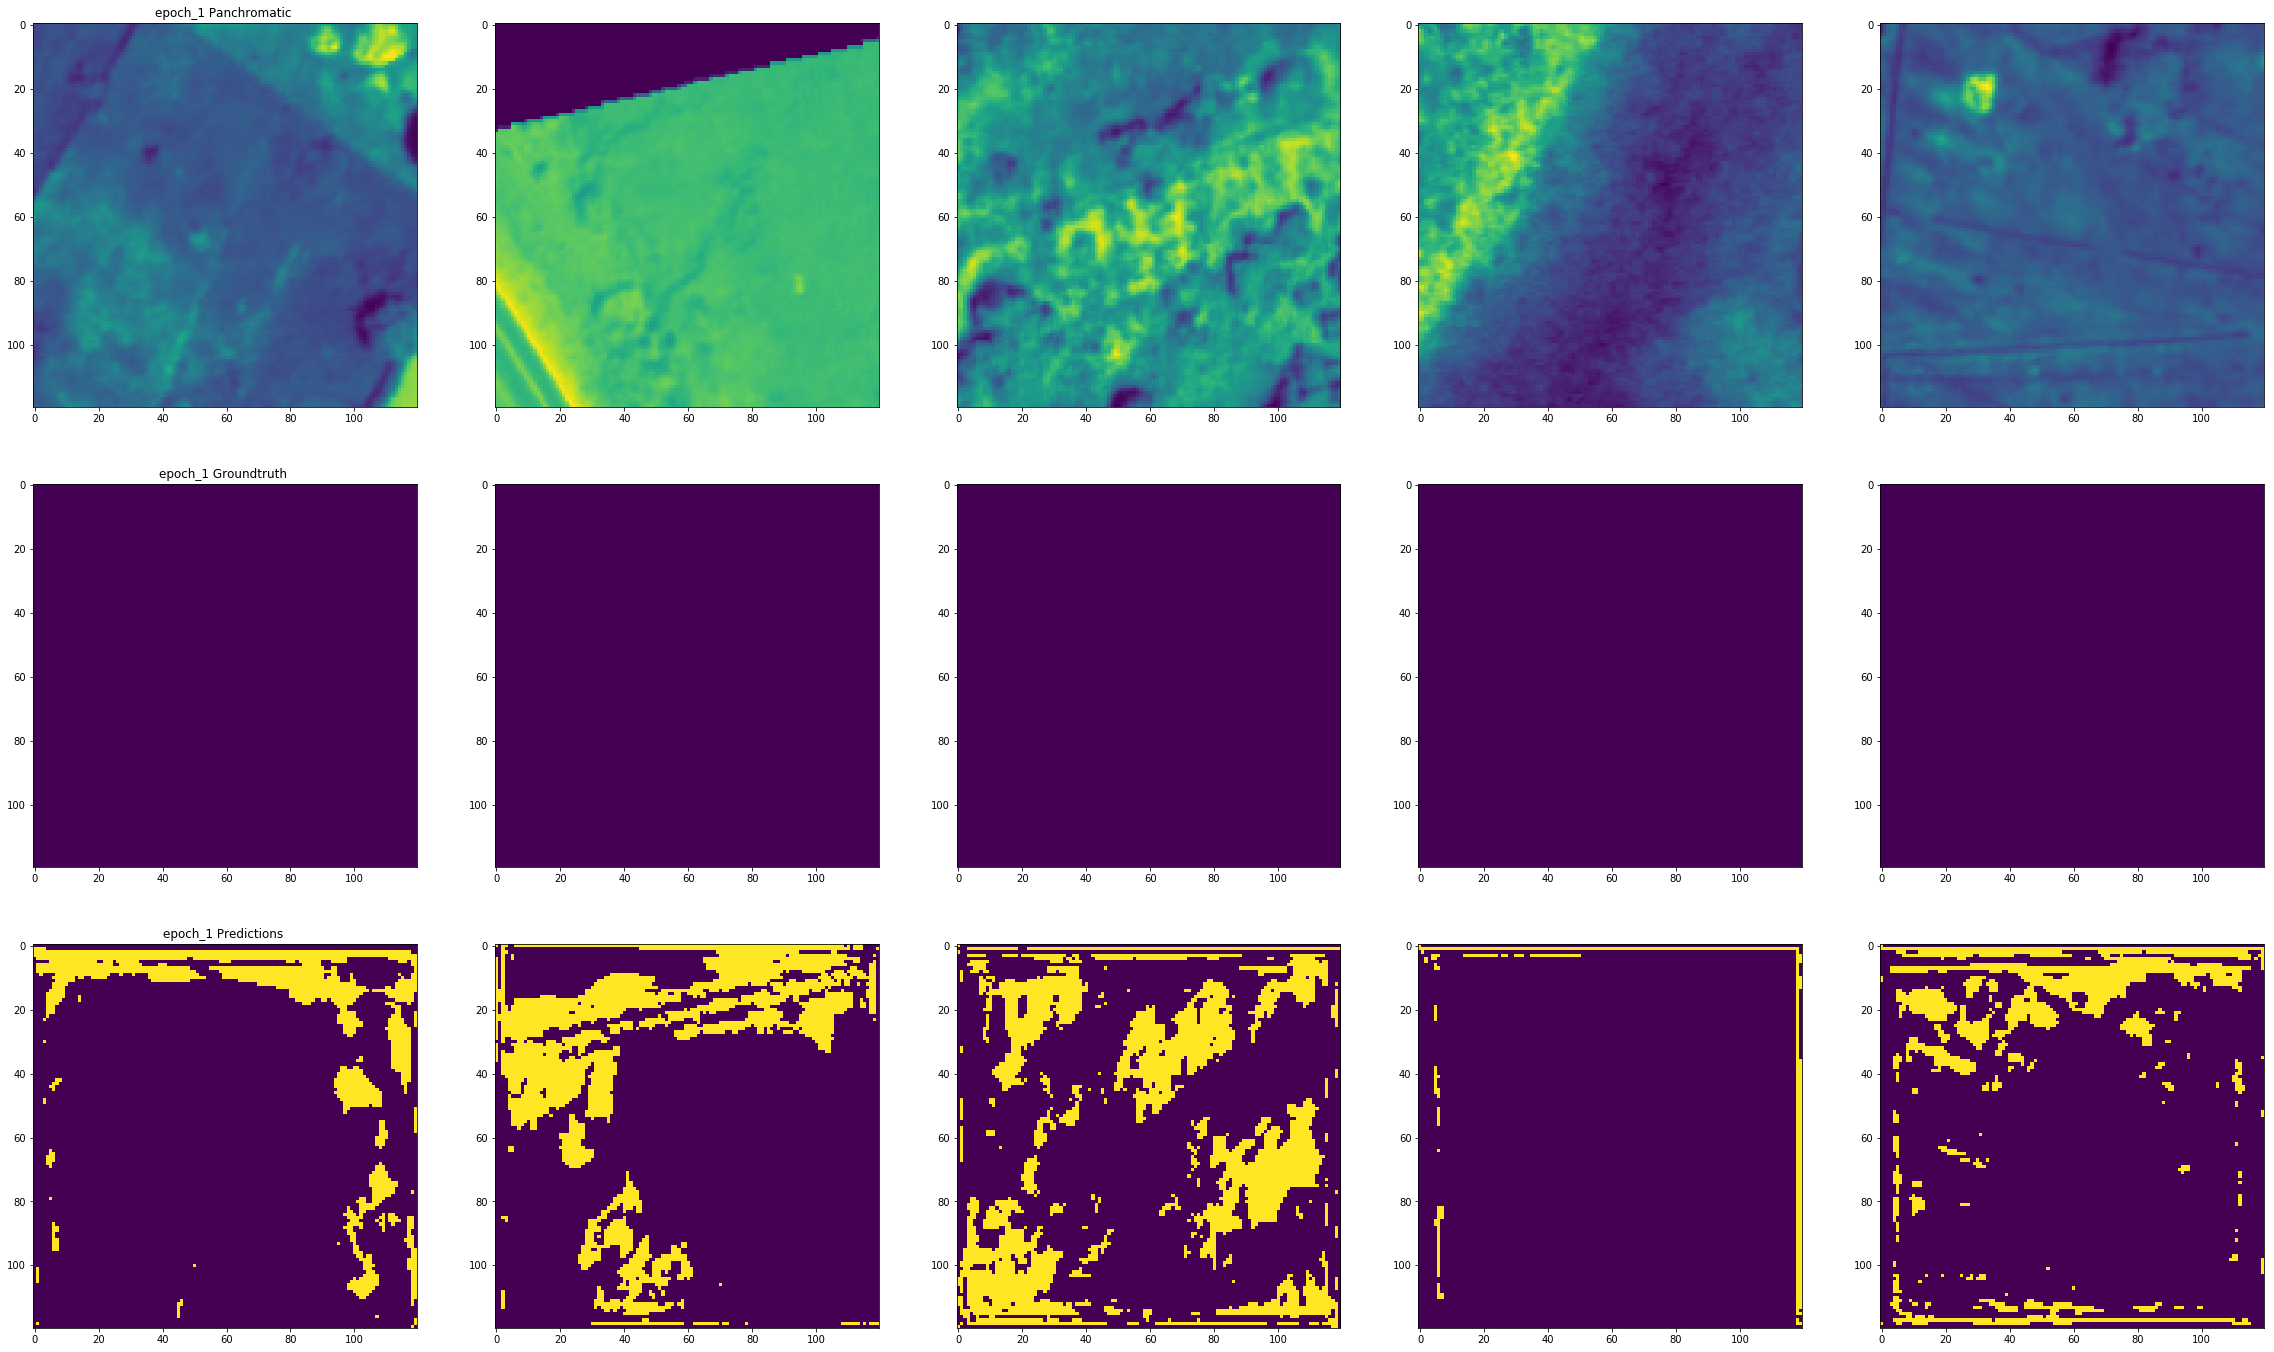

2018-03-27 21:46:42,681 Verification error= 13.6%, loss= 0.6858


torch.Size([5, 32, 120, 120])
torch.Size([5, 64, 60, 60])
torch.Size([5, 64, 60, 60])
torch.Size([5, 128, 30, 30])
torch.Size([5, 128, 30, 30])
torch.Size([5, 128, 15, 15])


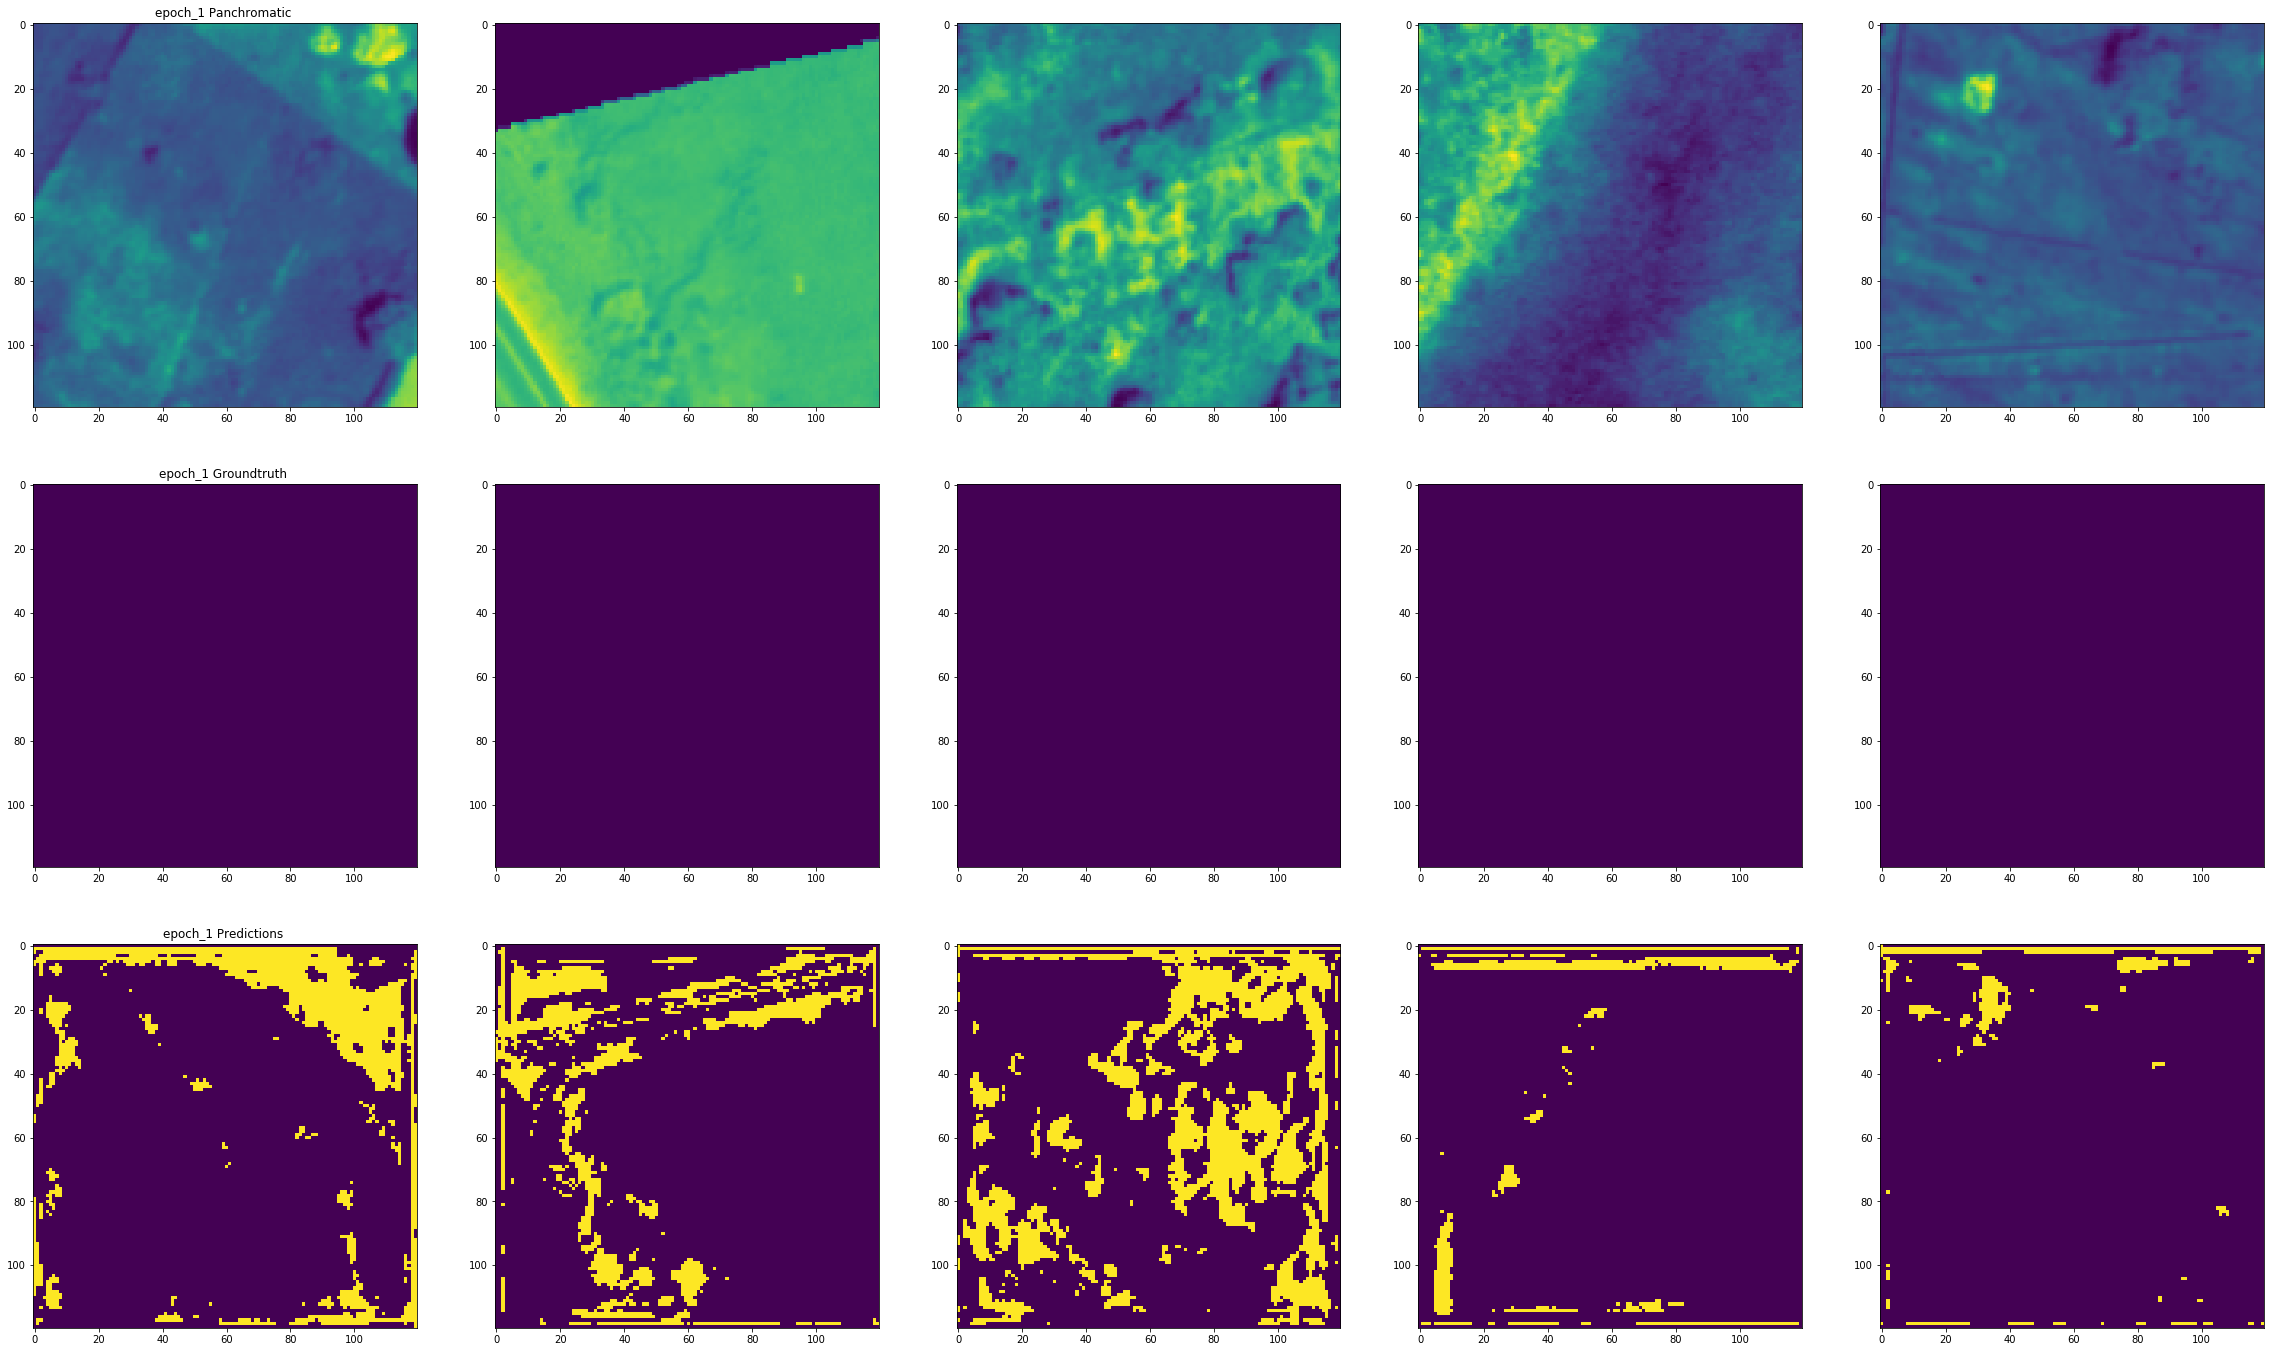

2018-03-27 21:46:44,744 Optimization Finished!


Checkpoint 6 saved !
Last model saved is MODEL_BASIC_TEST_120/RESUNET_BASIC_test.ckpt: 


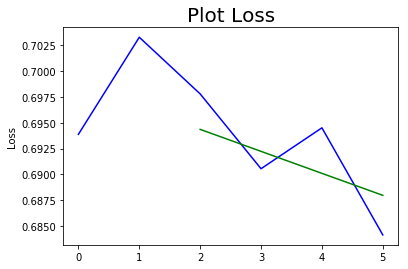

In [6]:
if __name__ == '__main__':

    
    model=UNet(INPUT_CHANNELS,NB_CLASSES,DEFAULT_LAYERS,DEFAULT_FEATURES_ROOT,DROPOUT)
    model.cuda()
    cudnn.benchmark = True
    
    root_folder = '../DATA_GHANA/DATASET/120_x_120_8_bands/'

    trainer=Trainer(model,DEFAULT_BATCH_SIZE,DEFAULT_LR)
    
    
    save_path,loss_train,loss_verif=trainer.train( root_folder, MODEL_PATH_SAVE, MODEL_PATH_RESTORE, DEFAULT_ITERATIONS,DEFAULT_EPOCHS,DROPOUT, DISPLAY_STEP, DEFAULT_VALID,REC_SAVE, TEST_SAVE)
    print('Last model saved is %s: '%save_path)
    #SAVE PSNR
    plt.title('Plot Loss', fontsize=20)
    ite = np.arange(0,DEFAULT_EPOCHS*DEFAULT_ITERATIONS,1)
    epo=np.arange((DEFAULT_ITERATIONS-1),(DEFAULT_EPOCHS*DEFAULT_ITERATIONS+(DEFAULT_ITERATIONS-1)),DEFAULT_ITERATIONS)
    plt.plot(ite,loss_train,'b',epo,loss_verif,'g')
    plt.ylabel('Loss')
    plt.show()


